In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
historical = ('/content/drive/MyDrive/503/historical_transactions.csv')
new = ('/content/drive/MyDrive/503/new_merchant_transactions.csv')
merchants = ('/content/drive/MyDrive/503/merchants.csv')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=Warning)
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/503/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/503/test.csv')

In [ ]:
new_transaction_data = pd.read_csv(new)
merchants_data = pd.read_csv(merchants)

In [ ]:
train_data.info() # 没有missing value
test_data.info() # 一个missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   first_active_month  123622 non-null  object
 1   card_id             123623 non-null  object
 2   feature_1           123623 non-null  int64 
 3   feature_2           123623 non-null  int64 
 4   feature_3          

In [ ]:
train_data.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [ ]:
test_data.describe()

,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


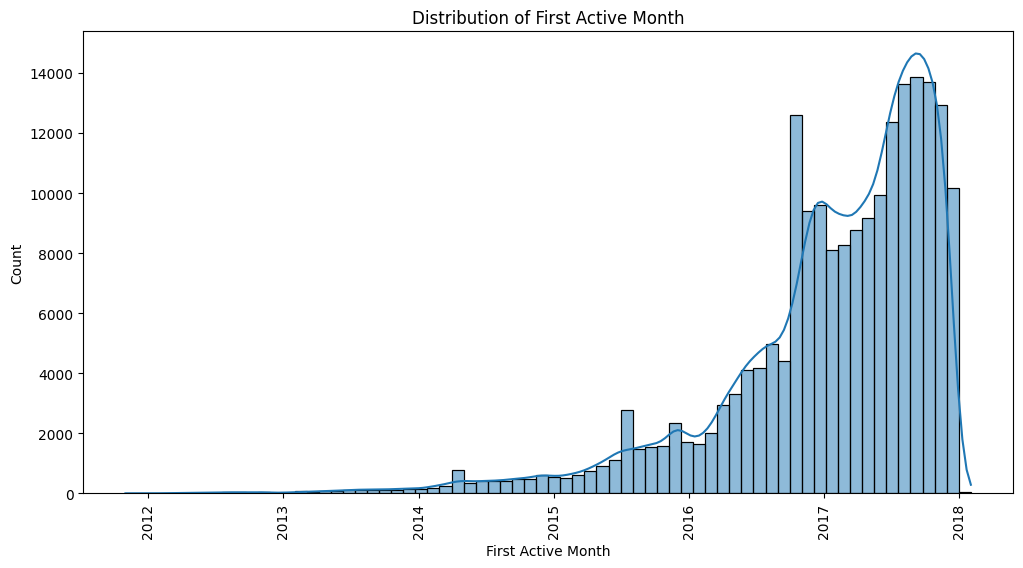

In [ ]:
# 对train data进行探索
# time sorting
train_data['first_active_month'] = pd.to_datetime(train_data['first_active_month'])
train_data = train_data.sort_values(by='first_active_month')
# 第一次激活月的分布
plt.figure(figsize=(12, 6))
sns.histplot(train_data['first_active_month'], bins=70, kde=True)
plt.xticks(rotation=90)
plt.xlabel('First Active Month')
plt.ylabel('Count')
plt.title('Distribution of First Active Month')
plt.show()
# 上升趋势

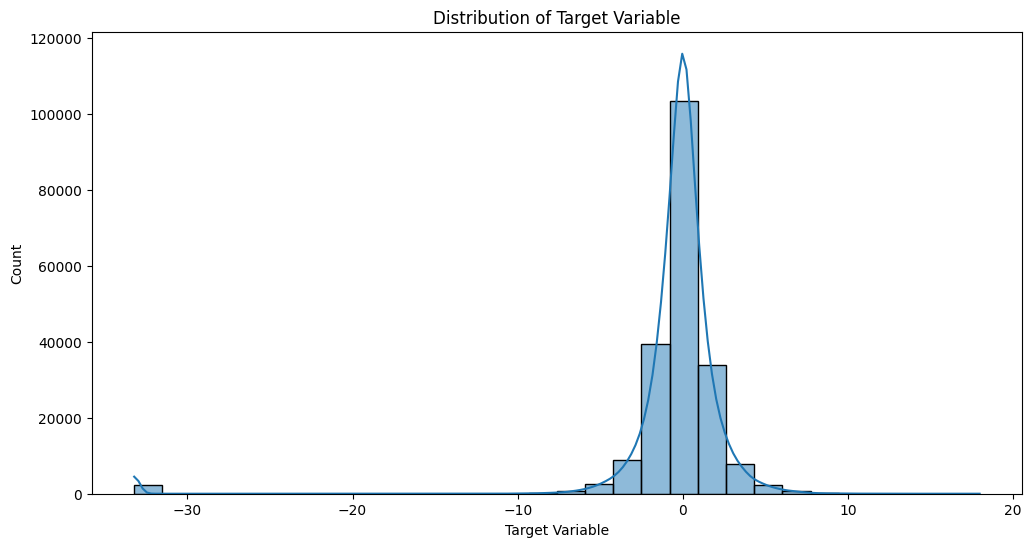

In [ ]:
# see the target distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_data['target'], bins=30, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()
# 有一小段在-30，最多的在0附近，正态分布

In [ ]:
# 分块处理historical transaction data
# 指定每一列的 dtype
dtype = {
    'card_id': 'category',
    'month_lag': 'int8',
    'authorized_flag': 'category',
    'category_3': 'category',
    'installments': 'int8',
    'category_1': 'category',
    'merchant_category_id': 'int16',
    'subsector_id': 'int16',
    'merchant_id': 'category',
    'purchase_amount': 'float32',
    'city_id': 'int16',
    'state_id': 'int16',
    'category_2': 'category'
}

chunk_size = 100000  # 设定块的大小，视内存情况而定
chunks = pd.read_csv(historical, dtype=dtype, chunksize=chunk_size, parse_dates=['purchase_date'])

processed_chunks = []

for chunk in chunks:
    # 对每块数据进行处理或预处理
    processed_chunks.append(chunk)

In [ ]:
# 将所有处理好的块合并
historical_transaction_data = pd.concat(processed_chunks, ignore_index=True)

In [ ]:
historical_transaction_data.shape

(29112361, 14)

In [ ]:
historical_transaction_data.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.00000000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.00000000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.00000000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.00000000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.00000000,16,37


In [ ]:
del processed_chunks
gc.collect()

0

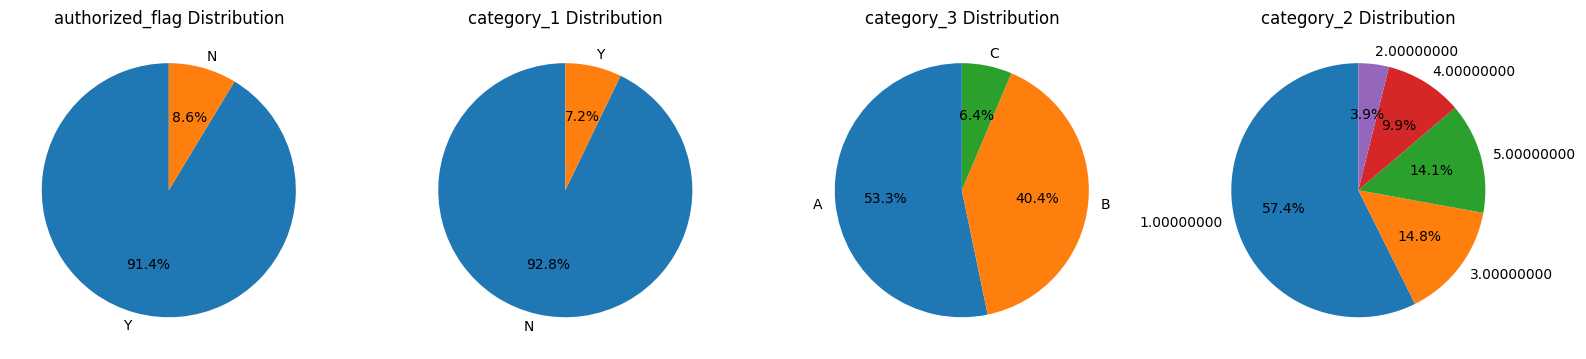

In [ ]:
columns_to_plot = ['authorized_flag', 'category_1', 'category_3', 'category_2']
num_columns = len(columns_to_plot)
fig, axes = plt.subplots(1, num_columns, figsize=(16, 6))
for i, col in enumerate(columns_to_plot):
    value_counts = historical_transaction_data[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{col} Distribution', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
historical_transaction_data['installments'].unique()
installments_counts = historical_transaction_data['installments'].value_counts()
month_lag_counts = historical_transaction_data['month_lag'].value_counts()

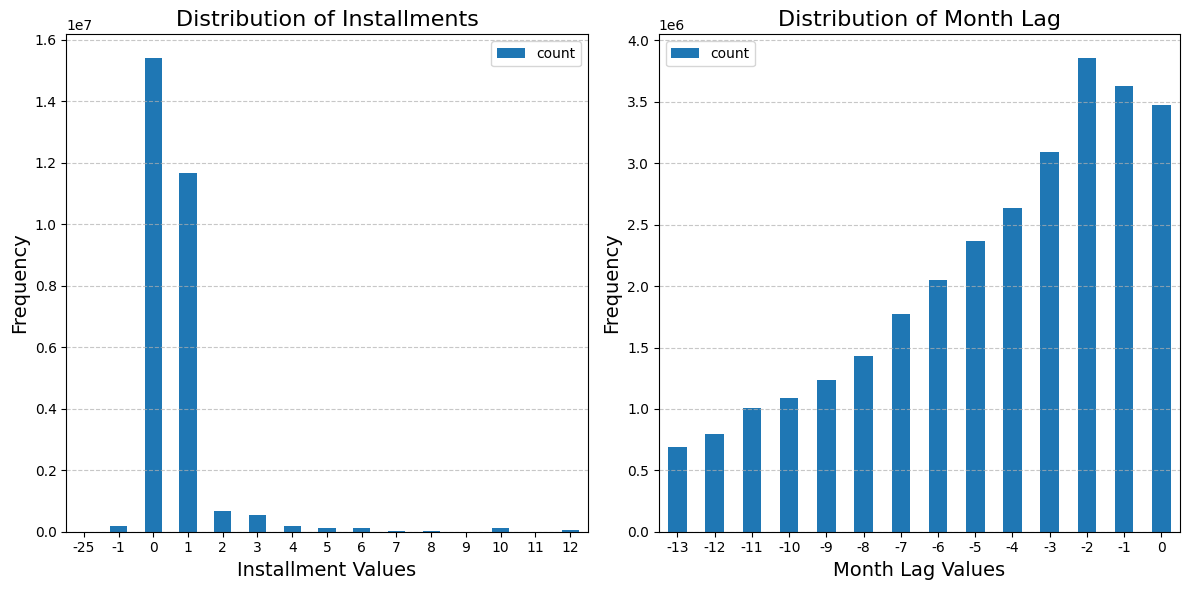

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
installments_counts.sort_index().plot(kind='bar')
plt.title('Distribution of Installments', fontsize=16)
plt.xlabel('Installment Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
month_lag_counts.sort_index().plot(kind='bar')
plt.title('Distribution of Month Lag', fontsize=16)
plt.xlabel('Month Lag Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
historical_transaction_data['installments_flag'] = historical_transaction_data['installments'].apply(lambda x: 1 if x in [-1, -25] else 0)
historical_transaction_data['installments'] = historical_transaction_data['installments'].replace([-1, -25], np.nan)

In [ ]:
historical_transaction_data['authorized_flag'].value_counts()

,count
authorized_flag,
Y,26595452
N,2516909


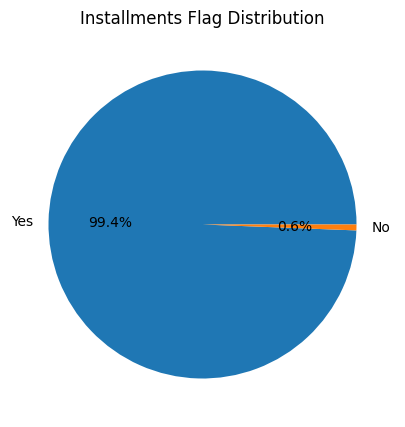

In [ ]:
plt.figure(figsize=(8, 5))
plt.pie(historical_transaction_data['installments_flag'].value_counts(), labels= ['Yes', 'No'], autopct='%1.1f%%')
plt.title('Installments Flag Distribution')
plt.show()

In [ ]:
# fill historical data missing value
historical_transaction_data['category_3'].value_counts()
historical_transaction_data['category_3'] = historical_transaction_data['category_3'].cat.add_categories('D')
historical_transaction_data['category_3'].fillna('D', inplace=True)
historical_transaction_data['category_3'].value_counts()

,count
category_3,
A,15411747
B,11677522
C,1844933
D,178159


In [ ]:
historical_transaction_data['category_2'].value_counts()
historical_transaction_data['category_2'] = historical_transaction_data['category_2'].cat.add_categories(6.0)
historical_transaction_data['category_2'].fillna(6.0, inplace=True)
historical_transaction_data['category_2'].value_counts()

,count
category_2,
1.00000000,15177199
3.00000000,3911795
5.00000000,3725915
6.0,2652864
4.00000000,2618053
2.00000000,1026535


In [ ]:
historical_transaction_data['merchant_id'].value_counts()
historical_transaction_data['merchant_id'].fillna('C_ID_272rop5ulu', inplace=True)

In [ ]:
historical_transaction_data.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,installments_flag
0,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.00000000,16,37,0
1,Y,C_ID_4e6213e9bc,88,N,0.0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.00000000,16,16,0
2,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.00000000,16,37,0
3,Y,C_ID_4e6213e9bc,88,N,0.0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.00000000,16,34,0
4,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.00000000,16,37,0


In [ ]:
historical_transaction_data['authorized_flag'] = historical_transaction_data['authorized_flag'].map({'Y':1, 'N':0}).astype(int)
historical_transaction_data['category_1'] = historical_transaction_data['category_1'].map({'Y':1, 'N':0}).astype(int)
historical_transaction_data['category_3'] = historical_transaction_data['category_3'].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
historical_transaction_data['category_2'] = pd.to_numeric(historical_transaction_data['category_2'])

In [ ]:
le = LabelEncoder()
historical_transaction_data['merchant_category_id'] = le.fit_transform(historical_transaction_data['merchant_category_id'])
historical_transaction_data['city_id'] = le.fit_transform(historical_transaction_data['city_id'])
historical_transaction_data['state_id'] = le.fit_transform(historical_transaction_data['state_id'])
historical_transaction_data['subsector_id'] = le.fit_transform(historical_transaction_data['subsector_id'])

In [ ]:
historical_transaction_data.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,installments_flag
0,1,C_ID_4e6213e9bc,76,0,0.0,0,31,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,36,0
1,1,C_ID_4e6213e9bc,76,0,0.0,0,133,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,15,0
2,1,C_ID_4e6213e9bc,76,0,0.0,0,31,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,36,0
3,1,C_ID_4e6213e9bc,76,0,0.0,0,214,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,33,0
4,1,C_ID_4e6213e9bc,76,0,0.0,0,31,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,36,0


In [ ]:
historical_transaction_data.drop(['merchant_id'], axis=1, inplace=True)

In [ ]:
# feature selection extract year month and day time of purchase
historical_transaction_data['purchase_date'] = pd.to_datetime(historical_transaction_data['purchase_date'])
historical_transaction_data['purchase_year'] = historical_transaction_data['purchase_date'].dt.year
historical_transaction_data['purchase_month'] = historical_transaction_data['purchase_date'].dt.month
historical_transaction_data['purchase_day'] = historical_transaction_data['purchase_date'].dt.day
historical_transaction_data['purchase_hour'] = historical_transaction_data['purchase_date'].dt.hour
historical_transaction_data['dayofweek'] = historical_transaction_data['purchase_date'].dt.dayofweek
historical_transaction_data['quarter'] = historical_transaction_data['purchase_date'].dt.quarter
historical_transaction_data['is_weekend'] = historical_transaction_data['purchase_date'].dt.dayofweek >= 5
historical_transaction_data.drop(['purchase_date'], axis=1, inplace=True)

In [ ]:
historical_transaction_data.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,installments_flag,purchase_year,purchase_month,purchase_day,purchase_hour,dayofweek,quarter,is_weekend
0,1,C_ID_4e6213e9bc,76,0,0.0,0,31,-8,-0.703331,1.0,16,36,0,2017,6,25,15,6,2,True
1,1,C_ID_4e6213e9bc,76,0,0.0,0,133,-7,-0.733128,1.0,16,15,0,2017,7,15,12,5,3,True
2,1,C_ID_4e6213e9bc,76,0,0.0,0,31,-6,-0.720386,1.0,16,36,0,2017,8,9,22,2,3,False
3,1,C_ID_4e6213e9bc,76,0,0.0,0,214,-5,-0.735352,1.0,16,33,0,2017,9,2,10,5,3,True
4,1,C_ID_4e6213e9bc,76,0,0.0,0,31,-11,-0.722865,1.0,16,36,0,2017,3,10,1,4,1,False


In [ ]:
# Using label encoding for year
le = LabelEncoder()
historical_transaction_data['purchase_year'] = le.fit_transform(historical_transaction_data['purchase_year'])

In [ ]:
def new_aggregate_cols(df, prefix):
    agg_func = {
        'authorized_flag': ['max', 'min', 'mean'],
        'installments_flag': ['max', 'min', 'mean'],
        'category_1': ['mean', 'nunique'],
        'category_2': ['mean', 'nunique'],
        'category_3': ['mean', 'nunique'],
        'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
        'purchase_year': ['min', 'max', 'mean', 'std'],
        'purchase_month': ['min', 'max', 'mean', 'std', 'nunique'],
        'purchase_day': ['min', 'max', 'mean', 'std', 'nunique'],
        'purchase_hour': ['min', 'max', 'mean', 'std'],
        'dayofweek': ['mean', 'nunique'],
        'quarter': ['mean', 'nunique'],
        'is_weekend': ['mean', 'nunique'],
        'month_lag': ['sum', 'mean', 'min', 'max', 'std'],
        'merchant_category_id': ['nunique'],
        'city_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique']
    }
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
# calculate mode add into agg_df
    mode_cols = ['category_1', 'category_2', 'category_3', 'merchant_category_id', 'city_id', 'state_id', 'subsector_id']
    for col in mode_cols:
        mode_df = df.groupby('card_id')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        mode_df = mode_df.rename(f"{prefix}{col}_mode")
        agg_df = agg_df.merge(mode_df, on='card_id', how='left')


    df1 = (df.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))

    agg_df = pd.merge(df1, agg_df, on='card_id', how='left')
    return agg_df

In [ ]:
history_trans = new_aggregate_cols(historical_transaction_data, prefix='hist_')
del historical_transaction_data
gc.collect()

0

In [ ]:
print(history_trans.describe())

       hist_transactions_count  hist_authorized_flag_max  \
count            325540.000000                  325540.0   
mean                 89.427907                       1.0   
std                 105.279414                       0.0   
min                   2.000000                       1.0   
25%                  26.000000                       1.0   
50%                  55.000000                       1.0   
75%                 111.000000                       1.0   
max                5582.000000                       1.0   

       hist_authorized_flag_min  hist_authorized_flag_mean  \
count             325540.000000              325540.000000   
mean                   0.153096                   0.893224   
std                    0.360081                   0.114473   
min                    0.000000                   0.030488   
25%                    0.000000                   0.852941   
50%                    0.000000                   0.926829   
75%                    0.

In [ ]:
def remove_outlier(df, col):
  for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [ ]:
# remove outlier function
numeric_cols = history_trans.select_dtypes(include=['int64', 'float64']).columns.tolist()
history_filter_data = remove_outlier(history_trans, 'numeric_cols')

In [ ]:
print(history_filter_data.describe())

       hist_transactions_count  hist_authorized_flag_max  \
count            301006.000000                  301006.0   
mean                 66.158000                       1.0   
std                  53.589347                       0.0   
min                   2.000000                       1.0   
25%                  25.000000                       1.0   
50%                  49.000000                       1.0   
75%                  93.000000                       1.0   
max                 238.000000                       1.0   

       hist_authorized_flag_min  hist_authorized_flag_mean  \
count             301006.000000              301006.000000   
mean                   0.164814                   0.889420   
std                    0.371013                   0.116945   
min                    0.000000                   0.030488   
25%                    0.000000                   0.846154   
50%                    0.000000                   0.923077   
75%                    0.

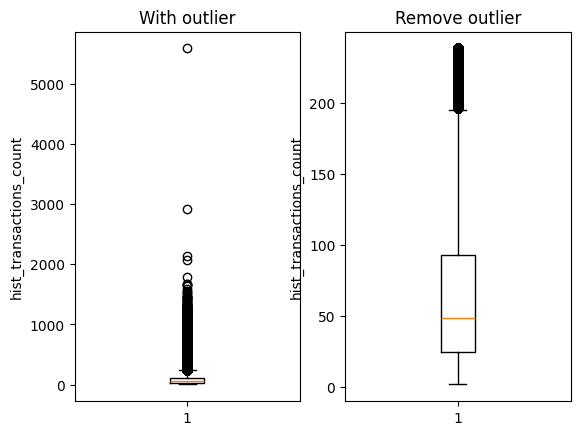

In [ ]:
# 可视化outlier in 'hist_transactions_count'
plt.subplot(1, 2, 1)
plt.boxplot(history_trans['hist_transactions_count'])
plt.title('With outlier')
plt.ylabel('hist_transactions_count')
plt.subplot(1, 2, 2)
plt.boxplot(history_filter_data['hist_transactions_count'])
plt.title('Remove outlier')
plt.ylabel('hist_transactions_count')
plt.show()

In [ ]:
sns.histplot(history_filter_data['hist_purchase_amount_sum'], bins=30, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()

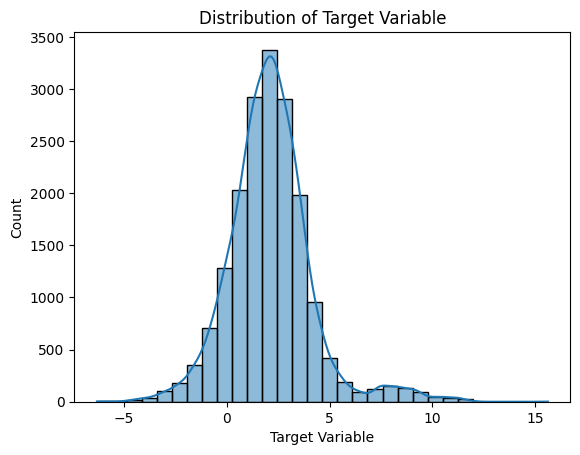

In [ ]:
history_filter_data['hist_purchase_amount_sum'] = np.log1p(history_filter_data['hist_purchase_amount_sum'])
sns.histplot(history_filter_data['hist_purchase_amount_sum'], bins=30, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()

In [ ]:
history_filter_data.describe()

In [ ]:
history_filter_data.to_csv('history_trans.csv', index=False)

In [ ]:
new_transaction_data.shape

In [ ]:
columns_to_plot = ['authorized_flag', 'category_1', 'category_3', 'category_2']
num_columns = len(columns_to_plot)
fig, axes = plt.subplots(1, num_columns, figsize=(16, 6))
for i, col in enumerate(columns_to_plot):
    value_counts = new_transaction_data[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{col} Distribution', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
installments_counts = new_transaction_data['installments'].value_counts()
month_lag_counts = new_transaction_data['month_lag'].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
installments_counts.sort_index().plot(kind='bar')
plt.title('Distribution of Installments', fontsize=16)
plt.xlabel('Installment Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
month_lag_counts.sort_index().plot(kind='bar')
plt.title('Distribution of Month Lag', fontsize=16)
plt.xlabel('Month Lag Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
new_transaction_data['installments_flag'] = new_transaction_data['installments'].apply(lambda x: 1 if x in [-1] else 0)
new_transaction_data['installments'] = new_transaction_data['installments'].replace([-1], np.nan)
new_transaction_data['installments'] = new_transaction_data['installments'].replace([999], new_transaction_data['installments'].mode()[0])

In [ ]:
new_transaction_data['installments'].value_counts()

In [ ]:
new_transaction_data.isnull().sum()
new_transaction_data['category_3'].value_counts()
new_transaction_data['category_3'].fillna('D', inplace=True)
# new_transaction_data['category_3'].value_counts()

In [ ]:
new_transaction_data['category_2'].value_counts()
new_transaction_data['category_2'].fillna(6.0, inplace=True)
# new_transaction_data['category_2'].value_counts()

In [ ]:
new_transaction_data['merchant_id'].value_counts()
new_transaction_data['merchant_id'].fillna('C_ID_272rop5ulu', inplace=True)

In [ ]:
new_transaction_data.shape

In [ ]:
merchants_data.shape

In [ ]:
merchants_data.isnull().sum()

In [ ]:
merchants_data.head()

In [ ]:
columns_to_plot = ['most_recent_sales_range', 'category_1', 'most_recent_purchases_range', 'category_2','category_4']
num_columns = len(columns_to_plot)
fig, axes = plt.subplots(1, num_columns, figsize=(16, 6))
for i, col in enumerate(columns_to_plot):
    value_counts = merchants_data[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{col} Distribution', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
active_months_lag6 = merchants_data['active_months_lag6'].value_counts()
active_months_lag3 = merchants_data['active_months_lag3'].value_counts()
active_months_lag12 = merchants_data['active_months_lag12'].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
active_months_lag3.sort_index().plot(kind='bar')
plt.title('Distribution of avtive months lag 3', fontsize=16)
plt.xlabel('Month Lag Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 3, 2)
active_months_lag6.sort_index().plot(kind='bar')
plt.title('Distribution of avtive months lag 6', fontsize=16)
plt.xlabel('Month Lag Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 3, 3)
active_months_lag12.sort_index().plot(kind='bar')
plt.title('Distribution of avtive months lag 12', fontsize=16)
plt.xlabel('Month Lag Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt
plt.tight_layout()
plt.show()

In [ ]:
#对merchant data进行预处理
# fill missing value
merchants_data['category_2'].value_counts()
merchants_data['category_2'].fillna(6.0, inplace=True)

In [ ]:
merchants_data['avg_sales_lag3'].fillna(merchants_data['avg_sales_lag3'].median(), inplace=True)
merchants_data['avg_sales_lag6'].fillna(merchants_data['avg_sales_lag6'].median(), inplace=True)
merchants_data['avg_sales_lag12'].fillna(merchants_data['avg_sales_lag12'].median(), inplace=True)

In [ ]:
# 处理 transaction data
# merge new transaction data and merchant data using merchantid
new_transaction_merchant_data= pd.merge( new_transaction_data, merchants_data, on='merchant_id', how='inner')
new_transaction_merchant_data.head()

,authorized_flag,card_id,city_id_x,category_1_x,installments,category_3,merchant_category_id_x,merchant_id,month_lag,purchase_amount,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id_y,state_id_y,category_2_y
0,Y,C_ID_415bb3a509,107,N,1.0,B,307,M_ID_b0c793002c,1,-0.557574,...,0.82,1.158625,6,0.81,1.235863,12,N,-1,9,1.0
1,Y,C_ID_415bb3a509,140,N,1.0,B,307,M_ID_88920c89e8,1,-0.569580,...,1.13,1.088138,6,1.13,1.102611,12,N,140,9,1.0
2,Y,C_ID_415bb3a509,330,N,1.0,B,507,M_ID_ad5237ef6b,2,-0.551037,...,1.03,1.055851,6,1.05,1.063897,12,N,-1,9,1.0
3,Y,C_ID_415bb3a509,-1,Y,1.0,B,661,M_ID_9e84cda3b1,1,-0.671925,...,1.11,1.177485,6,1.04,1.066582,12,Y,-1,-1,6.0
4,Y,C_ID_ef55cf8d4b,-1,Y,1.0,B,166,M_ID_3c86fa3831,1,-0.659904,...,0.68,0.653999,6,0.47,0.414029,12,Y,-1,-1,6.0


In [ ]:
new_transaction_merchant_data.drop(['merchant_id'], axis=1, inplace=True)
new_transaction_merchant_data.drop(['authorized_flag'], axis=1, inplace=True)
new_transaction_merchant_data['category_1_x'] = new_transaction_merchant_data['category_1_x'].map({'Y':1, 'N':0}).astype(int)
new_transaction_merchant_data['category_3'] = new_transaction_merchant_data['category_3'].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
new_transaction_merchant_data['category_4'] = new_transaction_merchant_data['category_4'].map({'N':0, 'Y':1}).astype(int)

In [ ]:
new_transaction_merchant_data['purchase_date'] = pd.to_datetime(new_transaction_merchant_data['purchase_date'])
new_transaction_merchant_data['purchase_year'] = new_transaction_merchant_data['purchase_date'].dt.year
new_transaction_merchant_data['purchase_month'] = new_transaction_merchant_data['purchase_date'].dt.month
new_transaction_merchant_data['purchase_day'] = new_transaction_merchant_data['purchase_date'].dt.day
new_transaction_merchant_data['purchase_hour'] = new_transaction_merchant_data['purchase_date'].dt.hour
new_transaction_merchant_data['dayofweek'] = new_transaction_merchant_data['purchase_date'].dt.dayofweek
new_transaction_merchant_data['quarter'] = new_transaction_merchant_data['purchase_date'].dt.quarter
new_transaction_merchant_data['is_weekend'] = new_transaction_merchant_data['purchase_date'].dt.dayofweek >= 5
new_transaction_merchant_data.drop(['purchase_date'], axis=1, inplace=True)

In [ ]:
new_transaction_merchant_data.info()

In [ ]:
def new_aggregate_cols(df, prefix):
    agg_func = {
    'city_id_x': ['nunique'],
    'category_1_x': ['nunique'],
    'category_3': ['mean', 'nunique'],
    'installments': ['mean', 'sum', 'min', 'max', 'std'],
    'merchant_category_id_x': ['nunique'],
    'month_lag': ['mean', 'sum', 'min', 'max', 'std'],
    'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
    'purchase_year': ['min', 'max', 'mean', 'std', 'nunique'],
    'purchase_month': ['min', 'max', 'mean', 'std', 'nunique'],
    'purchase_day': ['min', 'max', 'mean', 'std', 'nunique'],
    'purchase_hour': ['min', 'max', 'mean', 'std'],
    'dayofweek': ['mean', 'nunique'],
    'quarter': ['mean', 'nunique'],
    'is_weekend': ['mean', 'nunique'],
    'category_2_x': ['mean', 'nunique'],
    'state_id_x': ['nunique'],
    'installments_flag': ['mean', 'max', 'min'],
    'merchant_group_id': ['nunique'],
    'merchant_category_id_y': ['nunique'],
    'subsector_id_x': ['nunique'],
    'numerical_1': ['mean', 'sum', 'min', 'max', 'std'],
    'numerical_2': ['mean', 'sum', 'min', 'max', 'std'],
    'category_1_y': ['nunique'],
    'most_recent_sales_range': ['nunique'],
    'most_recent_purchases_range': ['nunique'],
    'avg_sales_lag3': ['mean', 'sum', 'min', 'max', 'std'],
    'avg_purchases_lag3': ['mean', 'sum', 'min', 'max', 'std'],
    'active_months_lag3': ['mean', 'sum', 'min', 'max', 'std'],
    'avg_sales_lag6': ['mean', 'sum', 'min', 'max', 'std'],
    'avg_purchases_lag6': ['mean', 'sum', 'min', 'max', 'std'],
    'active_months_lag6': ['mean', 'sum', 'min', 'max', 'std'],
    'avg_sales_lag12': ['mean', 'sum', 'min', 'max', 'std'],
    'avg_purchases_lag12': ['mean', 'sum', 'min', 'max', 'std'],
    'active_months_lag12': ['mean', 'sum', 'min', 'max', 'std'],
    'category_4': ['nunique'],
    'city_id_y': ['nunique'],
    'state_id_y': ['nunique']
}
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)

    df1 = (df.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))

    agg_df = pd.merge(df1, agg_df, on='card_id', how='left')
    return agg_df

In [ ]:
new_trans = new_aggregate_cols(new_transaction_merchant_data, prefix='new_')
del new_transaction_merchant_data
gc.collect()

15224

In [ ]:
new_trans.dropna(inplace=True)

In [ ]:
new_trans.describe()

In [ ]:
# remove outlier function
numeric_cols = new_trans.select_dtypes(include=['int64', 'float64']).columns.tolist()
new_filter_data = remove_outlier(new_trans, 'numeric_cols')

In [ ]:
new_filter_data.describe()

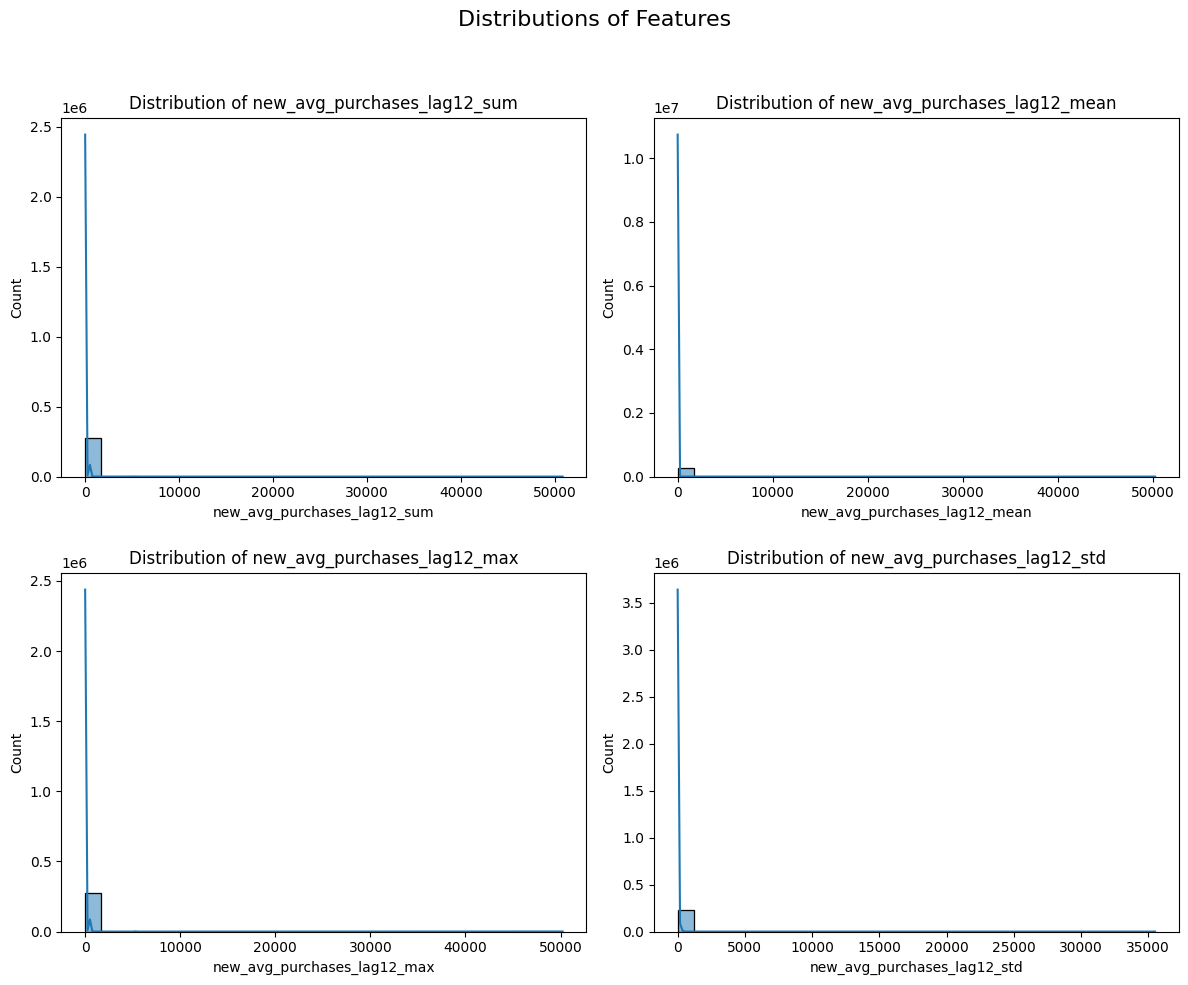

In [ ]:
boxplot_cols = ['new_avg_purchases_lag12_sum',
                'new_avg_purchases_lag12_mean',
                'new_avg_purchases_lag12_max',
                'new_avg_purchases_lag12_std']

# 设置子图的行数和列数
n_rows = 2
n_cols = 2

# 创建一个新的子图画布
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
fig.suptitle('Distributions of Features', fontsize=16)

# 遍历每个列并绘制到子图中
for i, col in enumerate(boxplot_cols):
    row = i // n_cols
    col_num = i % n_cols
    ax = axes[row, col_num]

    sns.histplot(new_filter_data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# 调整布局，避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 留出顶部空间给标题
plt.show()

In [ ]:
for col in boxplot_cols:
  new_filter_data[col] = np.log1p(new_filter_data[col])

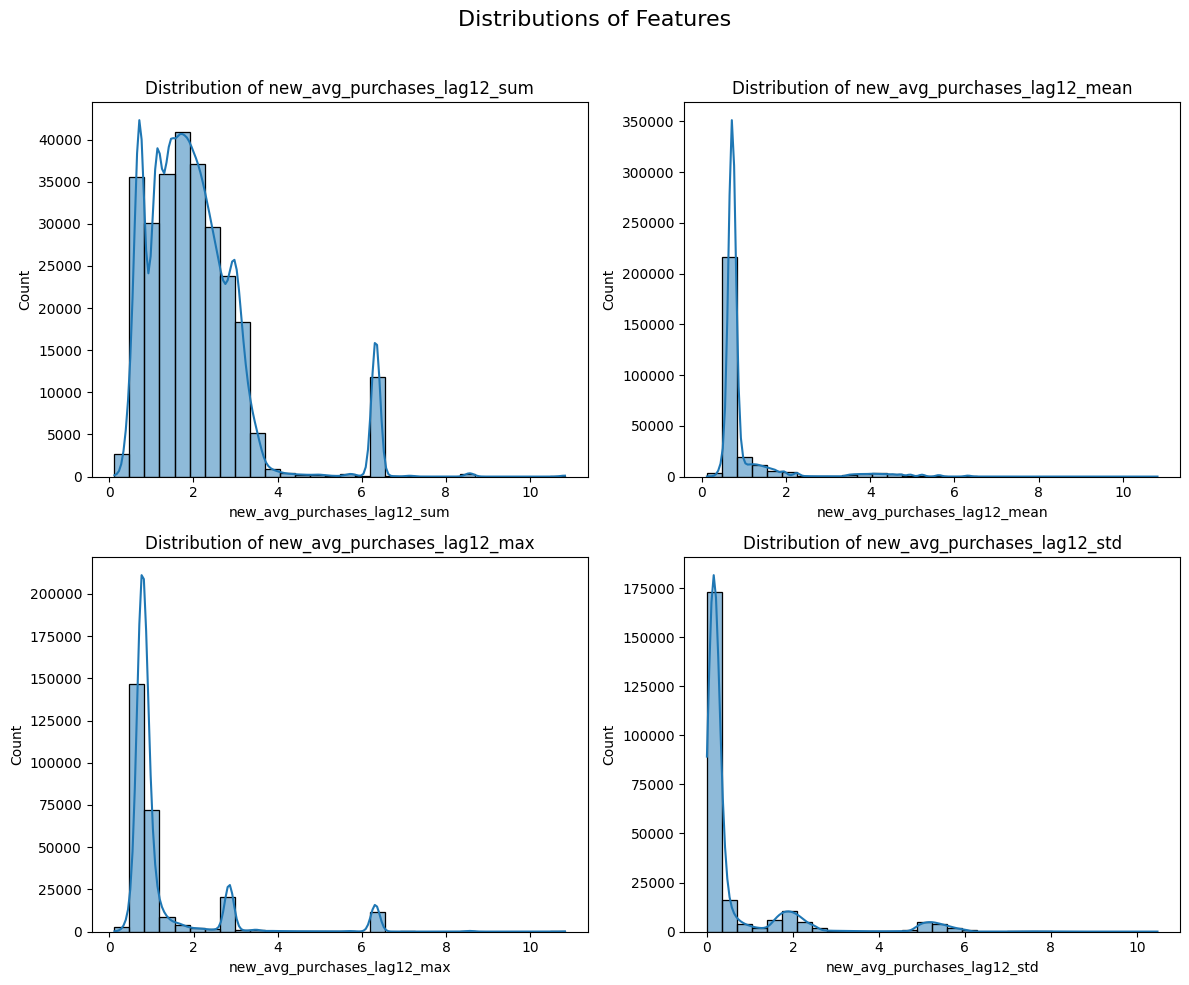

In [ ]:
# 创建一个新的子图画布
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
fig.suptitle('Distributions of Features', fontsize=16)

# 遍历每个列并绘制到子图中
for i, col in enumerate(boxplot_cols):
    row = i // n_cols
    col_num = i % n_cols
    ax = axes[row, col_num]

    sns.histplot(new_filter_data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# 调整布局，避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 留出顶部空间给标题
plt.show()

In [ ]:
new_filter_data.describe()

In [ ]:
# save 到csv file
new_filter_data.to_csv('new_transaction_merchant_data.csv', index=False)